# Parallel Processing in Python

author: Jacob Schreiber <br>
contact: jmschr@cs.washington.edu

Simply put, parallel processing is splitting up a task between many CPUs to make it work faster or more efficiently. In the big data setting this often means speading up complex analyses by splitting up the task across the CPUs and getting a speedup bounded by the additional number of cores added. This is made easier because most tasks on big data are embarassingly parallel, which means having many independent tasks that can be distributed to many cores easily. For example, matrix-matrix multiplication can be time intensive for big matrices. However, each row-column dot product is independent from each other and so can be given to a core without the need to communicate between cores mid-task. This is great for parallel processing.

While languages like C, Java, and R allow parallel processing fairly easily, life isn't easy being a Python programmer due to the Global Interpreter Lock (or GIL). This is a lock on a Python process which prevents it from executing multiple threads simultaneously. 

What does that even mean, though?

A process in a computer can be depicted as the following:

<img src="https://web.kudpc.kyoto-u.ac.jp/manual/sites/default/files/styles/large/public/thread_en.png"></img>
(ref: https://web.kudpc.kyoto-u.ac.jp/manual/en/parallel)

Your computer will allocate some memory for each process, which can be thought of as basically a "program." Every program is isolated from the others, and no process is allowed to infringe on the memory space of another process. If a process attempts to infringe on a neighbors space, this can lead to everyone's favorite error, the segfault.

Inside a process there can be multiple "threads" of execution. These threads share the underlying memory of the process, and can each be assigned to different cores for execution. This makes parallelization nice, because a process can load up some data and then process it using multiple cores much many people might eat a birthday cake.

However, having shared memory can cause problems. For example, imagine trying to sum a trillion numbers and saving it to a local variable "x". At some point, one of your lines of code will look something like `x = x + item`. However, if multiple threads grab the old value of "x" at the same time, add some number to it, and try to update the variable, you will get mistakes called "race conditions" which will cause you to get an incorrect sum. What's even worse is that the simpler the task, the higher the probability of these happening due to the frequency that these variables are being called. Lets take a look at a simple code example (without focusing too much on what the code itself says.)

In [1]:
%load_ext Cython
%pylab inline
import seaborn, time
seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force
import numpy
cimport numpy
from cython.parallel import prange

cdef int x, i

with nogil:
    x = 0
    for i in prange(10000000, schedule='guided', num_threads=4):
        (&x)[0] = (&x)[0] + 1

print x

2355706


Looks like we're getting a very wrong answer, and a different answer every time the code is run. This is where locks come in! Locks can be acquired by any thread and prevent other threads from executing. In this case, a thread could acquire a lock on x, update it, and then release the lock. This means only one thread is operating on x at a time. We can simulate that with the following code:

In [3]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force
import numpy
cimport numpy
from cython.parallel import prange

cdef int x, i

with nogil:
    x = 0
    for i in prange(10000000, schedule='guided', num_threads=4):
        with gil:
            (&x)[0] = (&x)[0] + 1

print x

10000000


However, there can still be race conditions if multiple threads can read a variable but then acquire the gil to update it sequentially. In fact, we have exactly the same problem as before, where multiple threads can read a variable and then overwrite each other's progress. We're just doing it in a more orderly fashion instead of a chaotic fashion. See the following code:

In [4]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force
import numpy
cimport numpy
from cython.parallel import prange

cdef int x, i, y

with nogil:
    x = 0
    for i in prange(1000000, schedule='guided', num_threads=4):
        y = x + 1
        with gil:
            (&x)[0] = y

print x

292763


Using the lock seemed to solve all of our issues, so what was the problem? Well, if we only have one thread running at a time, then we're not going to get any speed gain! Despite having distributed work to each of the seperate threads, only one of them is running at a time because we're constantly putting a lock on the work the threads are doing. We can see below roughly what was happening, where only one thread was allowed to do work at a time because it was acquiring and releasing a lock.

<img src="https://lh4.googleusercontent.com/HXDr4afwx28XEZgogOWBMEcaU0updIy_BsRqOnq7kaGVq3kEyXMlwmrDTvi9ZlMRI7fdW4TT5sPO4z_9kSVxlhrUznOdvK_rHQtP6pfic8ABrVcm3lOWPEoMH8sDKK2fMhw1YLI"></img>
(ref: www.tivix.com/blog/lets-go-python)

Now, the GIL is like a lock on a variable, except it's a lock on the entire Python process. This allows only one thread to be running at a time, no matter how many threads you create during the process of your program. This is a hotly contended issue amongst Pythonistas, but the general argument is that the Python interpreter was built to not be thread-safe because several speed gains could be made on that assumption, and since Python is pretty slow natively these speed gains are important.

It is still possible to do parallel processing in Python. The most naive way is to manually partition your data into independent chunks, and then run your Python program on each chunk. A computer can run multiple python processes at a time, just in their own unqiue memory space and with only one thread per process. This will be tedious, and you'll have to use another script to aggregate your answers. Pretty much, this sounds awful and you shouldn't do it. 

This process can be automated using the multiprocessing module.

## Multiprocessing

The simplest way to include parallel processing in your code is through the multiprocessing module which is built into python. The way this works is through the built-in pickle module, which is a way of serializing data, functions, and objects. In essense, you start up a pool of processes which wait for instructions from the main process. The main process will then send serialized data, methods, and objects, to the new process, and the new process will perform the instructions and send the result back. 

The module has a relatively simple interface, where you write a python method, create a pool of workers, and execute that function for different inputs. Lets see it in action for the simple task of taking in a series of numbers and returning the number of items and their sum.

First, define the method:

In [5]:
def summarize( X ):
    """Summarize the data set by returning the length and the sum."""
    return len(X), sum(X)

Now lets run this on a large amount of data in a purely sequential way to see what the answer is.

In [6]:
X = numpy.random.randn(1e7) + 8.342
x0, x1 = summarize(X)
print x1 / x0

8.34218972685


Looks like we're recovering the mean fairly well, as would be expected given the large number of samples. Now lets time this:

In [7]:
%timeit summarize(X)

100 loops, best of 3: 11.1 ms per loop


Seems fairly fast given that we have 1e7 elements. But it is a simple operation!

Using multiprocessing in Python involves first setting up a pool of workers and then distributing the tasks to each worker involving a subsection of the dataset.

In [8]:
from multiprocessing import Pool

p = Pool(4)
x = p.map( summarize, (X[i::4] for i in range(4)) )
print x

[(2500000, 20855745.504495542), (2500000, 20857531.901117966), (2500000, 20853282.111232795), (2500000, 20855337.751699924)]


This returns a list with each element being the output of one of the jobs. We have to sum through each job now to get the total aggregate.

In [9]:
x0 = sum( y0 for y0, _ in x )
x1 = sum( y1 for _, y1 in x )
print x1 / x0

8.34218972685


Looks like we're getting the same answer here! Now to time it:

In [10]:
%timeit p.map( summarize, (X[i::4] for i in range(4)) )

1 loops, best of 3: 220 ms per loop


That looks like it's at least an order of magnitude slower! But we're using parallel processing, how could things ever be slower? The reason mostly revolves around the operation being too simple and the data being too small. Here are some of the more prominent reasons:

(1) The cost of setting up the worker pool is very high given the cost of the original operation:

In [11]:
%timeit -n 3 Pool(4)

3 loops, best of 3: 24.9 ms per loop


(2) The memory cost of using this is high, because you're copying your initial data at least twice. This is because one full copy lives on the original process, and you have to send a partition of the data to this new process, which all has to live in memory.

(3) The cost of sending data across pipes can be higher than you want. Here is a speed comparison done by someone on StackOverflow:

```
mpenning@mpenning-T61:~$ python multi_pipe.py 
Sending 10000 numbers to Pipe() took 0.0369849205017 seconds
Sending 100000 numbers to Pipe() took 0.328398942947 seconds
Sending 1000000 numbers to Pipe() took 3.17266988754 seconds
mpenning@mpenning-T61:~$ python multi_queue.py 
Sending 10000 numbers to Queue() took 0.105256080627 seconds
Sending 100000 numbers to Queue() took 0.980564117432 seconds
Sending 1000000 numbers to Queue() took 10.1611330509 seconds
mpnening@mpenning-T61:~$ python multi_joinablequeue.py 
Sending 10000 numbers to JoinableQueue() took 0.172781944275 seconds
Sending 100000 numbers to JoinableQueue() took 1.5714070797 seconds
Sending 1000000 numbers to JoinableQueue() took 15.8527247906 seconds
mpenning@mpenning-T61:~$
```
(ref: http://stackoverflow.com/questions/8463008/python-multiprocessing-pipe-vs-queue)

This can be made faster, but it shows that especially for large datasets the time spent just piping the data can be significant.

So, if a significant portion of time is being spent piping data, then we can get better improvement with more cores if we have a more complex task. Basically each core is speeding through the summation and gulping down data as fast as possible. If we had a more complex task then the core would be spending more time on it and not need to be requesting new data as often.

Lets look at the case of pairwise sums, where we take in a list of numbers $x_{1}, \dots , x_{n}$ and return the sum of them all multiplied by each other, $\sum\limits_{i=1}^{n} \sum\limits_{j=1}^{n} x_{i}x_{j}$.  

In [12]:
def scalar_sum(X, y):
    return sum( x*y for x in X )

def pairwise_sum(X):
    return( sum( scalar_sum(X, y) for y in X ) )

Now lets show the single process version time:

In [13]:
X = numpy.random.randn(1000)
%timeit pairwise_sum(X)

1 loops, best of 3: 179 ms per loop


And a parallelized version. As a side note, we need a helper function to unwrap the arguments to the function since it has more than one function. It doesn't add a significant overhead to the program.

In [14]:
def scalar_wrapper(args):
    return scalar_sum(*args)

p = Pool(4)
%timeit p.map( scalar_wrapper, ((X, y) for y in X) )

10 loops, best of 3: 63.9 ms per loop


Looks like we're already getting a ~3x speed up when using 4 processes on this more complex operation!

Now, lets go to a real world example which can be very sped up using parallelization: Doing Expectation-Maximization on a Gaussian Mixture Model.

To begin with, a multivariate gaussian $G$ of dimensionality $d$ is parameterized by $mu$, which is a vector of mean values for each dimension, and $\Sigma$ which is the covariance matrix between all of these dimensions. The covariance matrix has a diagonal which is the variance of every dimension by itself, and each entry $\Sigma_{i,j}$ represents the covariance between dimension $i$ and dimension $j$. 

A mixture model requires that its underlying components have two operations: (1) they can return probabilities of data given that component $P(D|M)$, and (2) they can be fit to data. The expectation-maximization procedure then iterates between these two operations, using Bayes rule to calculate the probability of each component producing each point, and then updating the components based on these weighted beliefs.

Multivariate Gaussians have both of these operations. (1) The probability of a point under the multivariate Gaussian is as follows:

\begin{equation}
P(x|\mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^{d}|\Sigma|}}exp\left(-\frac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu)\right)
\end{equation}

Fortunately it's also implemented in scipy as a simple function for us. We can use this to create the expectation part of EM, which is calculating $P(M|D)$ for every data point and every component. We then normalize this matrix so that each row sums to 1, which defines the probability that each component generated that sample. Lastly, we do weighted MLE estimates to update the distributions.

We can see an example of it at work here:

<img src="http://twitwi.github.io/Presentation-2015-dirichlet-processes/gmm2d/difficult-soft.gif"</img></img>
(ref: http://twitwi.github.io/Presentation-2015-dirichlet-processes/gmm2d/difficult-soft.gif)

The colors added to the set are a bit confusing, but we can pretend that they don't matter. Roughly, we believe that the data was generated from three components, and want to be able to identify the underlying distributions which generated the data. We start off with rough, and very incorrect estimates, and then move towards better estimates iteratively until we converge at good solutions.

In [15]:
from scipy.stats import multivariate_normal

def expectation(X, mus, covs):
    r = numpy.hstack([multivariate_normal.pdf(X, mu, cov)[:, numpy.newaxis] for mu, cov in zip(mus, covs)])
    r = ( r.T / r.T.sum(axis=0) ).T
    return r

def covariance(X, weights):
    n, d = X.shape
    mu = numpy.average(X, axis=0, weights=weights)
    cov = numpy.zeros((d, d))
    
    for i in range(d):
        for j in range(i+1):
            cov[i, j] = weights.dot( (X[:,i] - mu[i])*(X[:,j] - mu[j])  )
            cov[j, i] = cov[i, j]
    
    w_sum = weights.sum()
    return cov / w_sum

def maximization(X, r):
    mus = numpy.array([ numpy.average(X, axis=0, weights=r[:,i]) for i in range(r.shape[1]) ])
    covs = numpy.array([ covariance(X, r[:,i]) for i in range(r.shape[1]) ])
    return mus, covs

We now have the two components which we need for the EM algorithm-- the expectation step and the maximization step. We just need to repeat these two steps until we achieve convergence. Instead of writing a convergence calculator we're just going to run the algorithm some fixed number of times until convergence,

In [16]:
def EM(X, mu, cov):
    for i in range(50):
        r = expectation(X, mu, cov)
        mu, cov = maximization(X, r)

    return mu, cov, r

Great. So we have a function now which will take in some initial values, and iterate until convergence, and return those values.

Lets generate some data with 4 underlying components

/home/jmschr/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


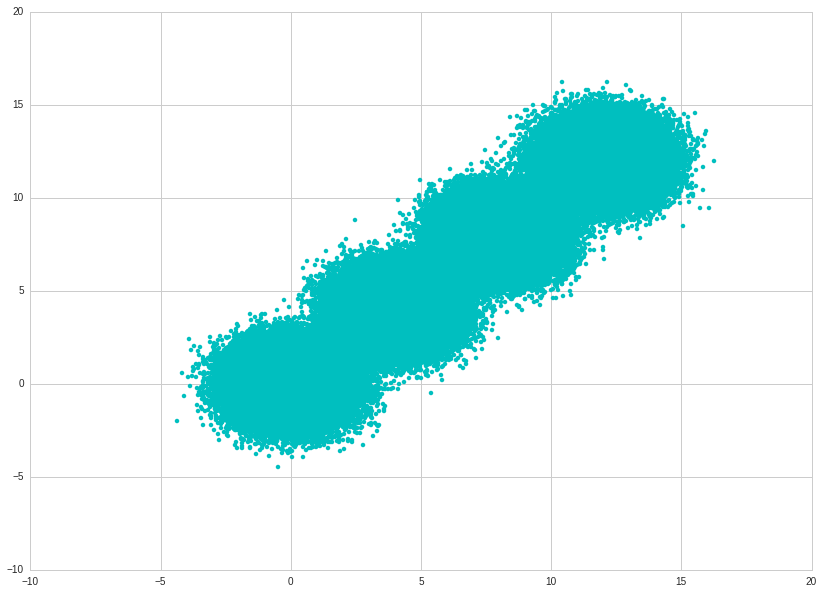

In [17]:
d, m = 2, 4
X = numpy.concatenate([numpy.random.randn(100000, d)+i*4 for i in range(m)])  

plt.figure( figsize=(14, 10) )
plt.scatter( X[:,0], X[:,1], c='c', linewidth=0 )

Now lets run the sequential algorithm and plot the results.

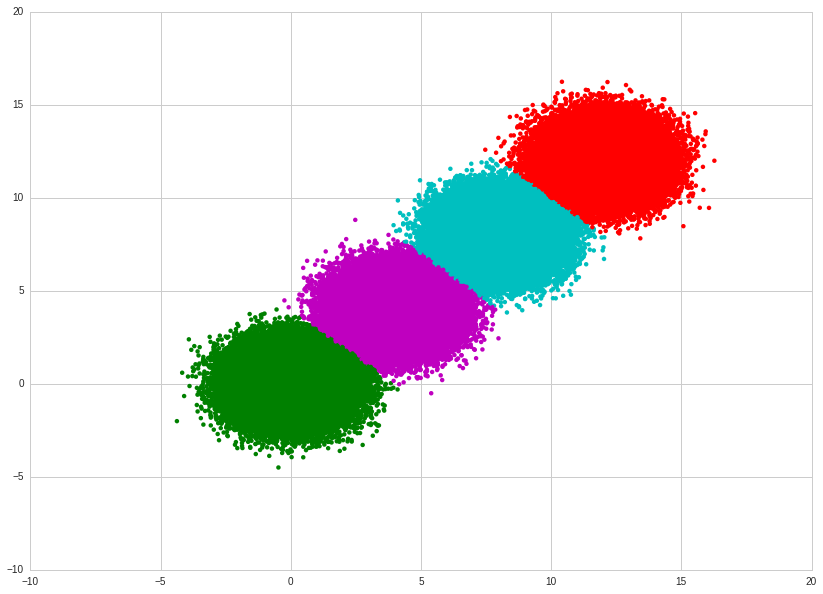

EM took 17.1618189812s


In [18]:
mu = numpy.random.randn(m, d) + X.mean(axis=0)
cov = numpy.array([numpy.eye(d) for i in range(m)])

tic = time.time()
mu, cov, r = EM(X, mu, cov)
toc = time.time() - tic

r = r.argmax(axis=1)
plt.figure( figsize=(14, 10) )
plt.scatter( X[:,0], X[:,1], c=['cmgr'[i] for i in r], linewidth=0 )
plt.show()
print "EM took {}s".format(toc)

However, the calculation of the responsibility matrix in the expectation step is embarassingly parallel. We can either use model parallelism, where we break the model up across processes and have it analyze the same data, or data parallelism, where we break up the data across processes and have the full model analyze the partition of the data.

If we try to do this using the multiprocessing module, we will usually run into a memory error. This is because we have to create a new pool of workers each process, and pipe the data to each worker. The module doesn't have great shutting down of idle processes, and so in an iterative algorithm like EM you will frequently get several hundreds of idle processes all with a huge slice of the data taking up memory. Since we are implementing model parallelism, this gets especially bad, because each process will have a full copy of the data stored on it.

How do we deal with this, then?

## joblib

joblib is a parallel processing library for python which was developed by many of the same people who work on scikit-learn, and is widely used inside scikit-learn to parallelize some of their algorithms. It is built on top of the multiprocessing and multithreading libraries in order to support both (multithreaded will be talked about later) but has a significant portion of additional features. One of the biggest ones is the ability to use a pool of workers like a context manager which can be reused across many tasks to be parallelized. This means each iteration of EM can use the same pool of workers. Newer versions will also actively time the duration of the tasks being dispatched to the processes to create an optimal schedule for splitting up data chunks. Lastly, if the number of jobs is set to 1, it will work in a purely sequential mode, with no overhead of setting up a pool or dispatching data.

Lets see how to use it below:

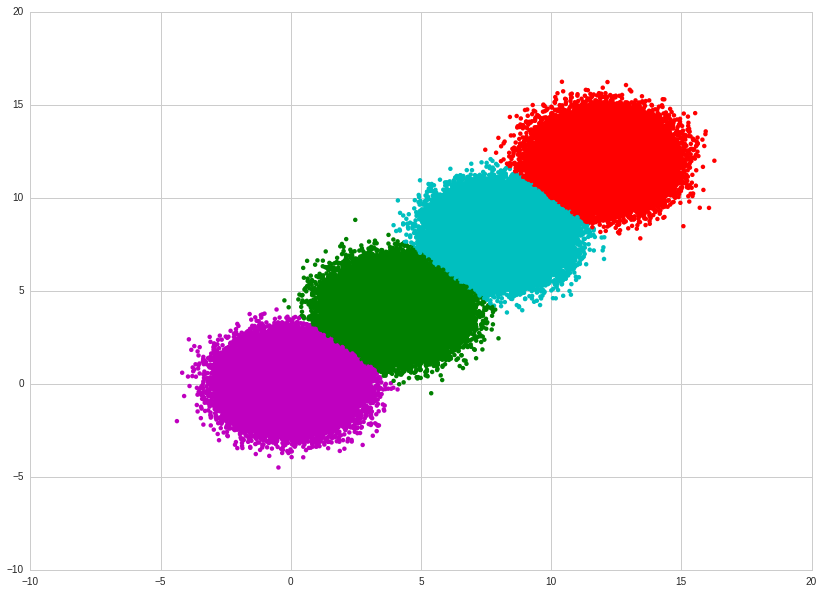

EM took 17.5145511627s


In [19]:
from joblib import Parallel, delayed

def _expectation(X, mu, cov):
    return multivariate_normal.pdf(X, mu, cov)[:, numpy.newaxis]

def _expectation_wrapper(args):
    return _expectation(*args)

def expectation(X, mus, covs, parallel):
    tasks = ((X, mu, cov) for mu, cov in zip(mus, covs))
    r = numpy.hstack( parallel( delayed(_expectation_wrapper)(t) for t in tasks ) )
    r = ( r.T / r.T.sum(axis=0) ).T
    return r

def EM(X, mu, cov):
    with Parallel(n_jobs=4) as parallel: 
        for i in range(50):
            r = expectation(X, mu, cov, parallel)
            mu, cov = maximization(X, r)

    return mu, cov, r

mu = numpy.random.randn(m, d) + X.mean(axis=0)
cov = numpy.array([numpy.eye(d) for i in range(m)])

tic = time.time()
mu, cov, r = EM(X, mu, cov)
toc = time.time() - tic

r = r.argmax(axis=1)
plt.figure( figsize=(14, 10) )
plt.scatter( X[:,0], X[:,1], c=['cmgr'[i] for i in r], linewidth=0 )
plt.show()
print "EM took {}s".format(toc)

It looks like we're not getting a speed increase despite using parallel processing. This is likely because of the overhead costs of setting up the pool and piping data between the processes can be quite high. It might be time to move back to multi-threading, since we're having limited success with multiprocessing.

## Multithreading

We did not immediately use threading because the GIL prevented multiple threads from being executed at the same time. However, it is possible to release the GIL if we use cython, which is a compiler for both native Python code and its extension, also called Cython. Lets look into parallelizing the pairwise sum problem first in cython.

In [20]:
X = numpy.random.randn(5000)

Lets first take a look at the raw python code and see how long it takes.

In [21]:
def scalar_sum(X, y):
    return sum( x*y for x in X )

def pairwise_sum(X):
    return( sum( scalar_sum(X, y) for y in X ) )

%timeit pairwise_sum(X)

1 loops, best of 3: 4.4 s per loop


Now lets keep the code the same but turn cython on and see how long it takes.

In [22]:
%%cython

def scalar_sum(X, y):
    return sum( x*y for x in X )

def pairwise_sum(X):
    return( sum( scalar_sum(X, y) for y in X ) )

In [23]:
%timeit pairwise_sum(X)

1 loops, best of 3: 3.35 s per loop


Looks like we're getting a pretty good speed increase without even modifying the code!

Now lets use some static typing of variables to utilize the Cython extension language. Since `scalar_sum` is the primary workhorse, lets focus on just improving that one for now.

In [24]:
%%cython

cdef double scalar_sum(double[:] X, double y):
    cdef int i
    cdef double _sum = 0.0
    
    for i in range(X.shape[0]):
        _sum += X[i] * y
    
    return _sum

def pairwise_sum(X):
    return( sum( scalar_sum(X, y) for y in X ) )

In [25]:
%timeit pairwise_sum(X)

10 loops, best of 3: 25.4 ms per loop


Looks like a pretty good speed increase there! Static typing is one of the main boosts in speed you can get from Cython, because it can be very expensive to have to infer the type for numerics if you have to constantly repeat the checks.

Now lets cythonize the `pairwise_sum` component as well, to make the entire thing written in the Cython extension language.

In [26]:
%%cython

cdef double scalar_sum(double[:] X, double y):
    cdef int i
    cdef double _sum = 0.0
    
    for i in range(X.shape[0]):
        _sum += X[i] * y
    
    return _sum

cpdef pairwise_sum(double[:] X):
    cdef int i
    cdef double _sum = 0.0
    
    for i in range(X.shape[0]):
        _sum += scalar_sum(X, X[i])
        
    return _sum

In [27]:
%timeit pairwise_sum(X)

10 loops, best of 3: 22.5 ms per loop


Now lets remove the GIL. In order to remove the GIL we need to make sure that the code with the GIL removed obeys several rules:

(1) Only statically typed variasbles of C primitives (int, long, double...)

(2) Arrays must be represented using pointers instead of numpy arrays or memoryviews

(3) No python object or methods at all

(4) All functions called must be tagged with `nogil` at the end

We then specify when we want to remove the GIL through the use of a context manager `with gil` and `with nogil` depending on what you want to do.

In [28]:
%%cython
cimport numpy

cdef double scalar_sum(double* X, double y, int n) nogil:
    cdef int i
    cdef double _sum = 0.0
    
    for i in range(n):
        _sum += X[i] * y
    
    return _sum

cpdef pairwise_sum(numpy.ndarray X_ndarray):
    cdef int i, n = X_ndarray.shape[0]
    cdef double* X = <double*> X_ndarray.data
    cdef double _sum = 0.0
    
    with nogil:
        for i in range(n):
            _sum += scalar_sum(X, X[i], n)
        
    return _sum

In [29]:
%timeit pairwise_sum(X)

10 loops, best of 3: 23.5 ms per loop


Now we can parallelize this function by changing the range to prange. There are a variety of great scheduling techniques to assign chunks of data to the various threads, but `guided` usually works the fastest in my experience.

In [30]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force
cimport numpy
from cython.parallel cimport prange

cdef double scalar_sum(double* X, double y, int n) nogil:
    cdef int i
    cdef double _sum = 0.0
    
    for i in range(n):
        _sum += X[i] * y
    
    return _sum

cpdef pairwise_sum(numpy.ndarray X_ndarray):
    cdef int i, n = X_ndarray.shape[0]
    cdef double* X = <double*> X_ndarray.data
    cdef double _sum = 0.0
    
    with nogil:
        for i in prange(n, schedule='guided', num_threads=4):
            _sum += scalar_sum(X, X[i], n)
        
    return _sum

In [31]:
%timeit pairwise_sum(X)

100 loops, best of 3: 6.16 ms per loop


However, a major problem is that we can't use openmp on Windows machines, so if you want to write code which works cross-platform, or just on Windows, you need to use a different solution. This is where joblib comes in again, because it has both a multiprocessing and a multithreading backend.

We can use the same `scalar_sum` code from before exactly, but we need to make a few modifications since joblib works on the python level, but releasing the gil requires you to be on the C level.

In [32]:
%%cython
cimport numpy
from joblib import Parallel, delayed

cdef double scalar_sum(double* X, double y, int n) nogil:
    cdef int i
    cdef double _sum = 0.0
    
    for i in range(n):
        _sum += X[i] * y
    
    return _sum

cpdef double scalar_wrapper(numpy.ndarray X_ndarray, double y):
    cdef double* X = <double*> X_ndarray.data
    cdef double _sum
    
    with nogil:
        _sum = scalar_sum(X, y, X_ndarray.shape[0])
    return _sum

cpdef pairwise_sum(numpy.ndarray X):
    cdef double _sum
    
    with Parallel(n_jobs=4, backend='threading') as parallel:
        _sum = sum( parallel([delayed(scalar_wrapper, check_pickle=False)(X, y) for y in X ]) )
        
    return _sum

In [33]:
%timeit pairwise_sum(X)

1 loops, best of 3: 1.21 s per loop


There is a lot of overhead here with going between python and cython as individual points are passed. So lets chunk the data and send all of the elements of $X$ which it is responsible for summing. 

In [34]:
%%cython
cimport numpy
from joblib import Parallel, delayed

cdef double scalar_sum(double* X, double* y, int n, int m) nogil:
    cdef int i, j
    cdef double _sum = 0.0
    
    for i in range(n):
        for j in range(m):
            _sum += X[i] * y[j]
    
    return _sum

cpdef double scalar_wrapper(numpy.ndarray X_ndarray, numpy.ndarray y_ndarray):
    cdef double* X = <double*> X_ndarray.data
    cdef double* y = <double*> y_ndarray.data
    cdef int n = X_ndarray.shape[0], m = y_ndarray.shape[0]
    cdef double _sum
    
    with nogil:
        _sum = scalar_sum(X, y, n, m)
    return _sum

cpdef pairwise_sum(numpy.ndarray X, int num_threads=1):
    cdef double _sum
    
    with Parallel(n_jobs=num_threads, backend='threading') as parallel:
        _sum = sum( parallel([ delayed(scalar_wrapper, check_pickle=False)(X, X[i::num_threads]) for i in range(num_threads) ]) )
        
    return _sum

In [35]:
X = numpy.random.randn(100000)
%timeit pairwise_sum(X, 1)

1 loops, best of 3: 8.99 s per loop


In [36]:
%timeit pairwise_sum(X, 4)

1 loops, best of 3: 2.33 s per loop


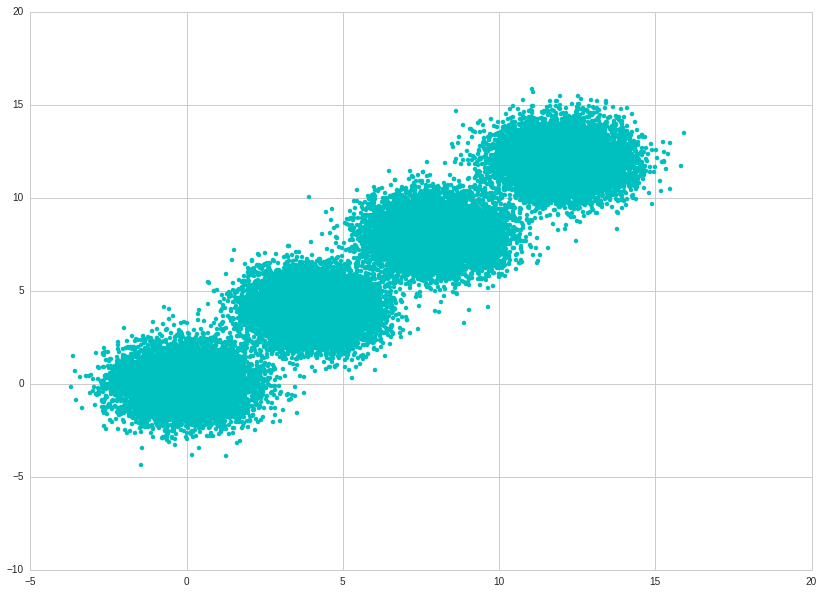

In [37]:
d, m = 2, 4
X = numpy.concatenate([numpy.random.randn(10000, d)+i*4 for i in range(m)]).astype('float64')
initial_mu = numpy.random.randn(m, d)*5 + X.mean(axis=0)
initial_cov = numpy.array([numpy.eye(d) for i in range(m)])

plt.figure( figsize=(14, 10) )
plt.scatter( X[:,0], X[:,1], c='c', linewidth=0 )

In [38]:
import numpy
LOG_2_PI = numpy.log(2*numpy.pi)

def log_probability(X, mu, inv_cov, log_det, d):
    logp = 0.0
    
    for i in range(d):
        for j in range(d):
            logp += (X[i] - mu[i]) * (X[j] - mu[j]) * inv_cov[i, j]
    
    return -0.5 * (d * LOG_2_PI + log_det + logp)
            
def _expectation(X, mu, cov ):
    n = X.shape[0]
    d = X.shape[1]
    log_det = numpy.linalg.slogdet(cov)[1]
    inv_cov_ndarray = numpy.linalg.inv(cov)
    r = numpy.zeros(n)
    
    for i in range(n):
        r[i] = numpy.exp(log_probability(X[i], mu, inv_cov_ndarray, log_det, d ))
    
    return r

def expectation(X, mu, cov):
    r = numpy.hstack((_expectation(X, m, c)[:, numpy.newaxis] for m, c in zip(mu, cov)))
    r = ( r.T / r.T.sum(axis=0) ).T
    return r
    
def covariance(X, weights):
    n, d = X.shape
    mu = numpy.average(X, axis=0, weights=weights)
    cov = numpy.zeros((d, d))
    
    for i in range(d):
        for j in range(i+1):
            cov[i, j] = weights.dot( (X[:,i] - mu[i])*(X[:,j] - mu[j])  )
            cov[j, i] = cov[i, j]
    
    w_sum = weights.sum()
    return cov / w_sum
    
def maximization(X, r):
    mus = numpy.array([ numpy.average(X, axis=0, weights=r[:,i]) for i in range(r.shape[1]) ])
    covs = numpy.array([ covariance(X, r[:,i]) for i in range(r.shape[1]) ])
    return mus, covs
    
def EM(X, mu, cov):
    for i in range(25):
        r = expectation(X, mu, cov)
        mu, cov = maximization(X, r)

    return mu, cov, r

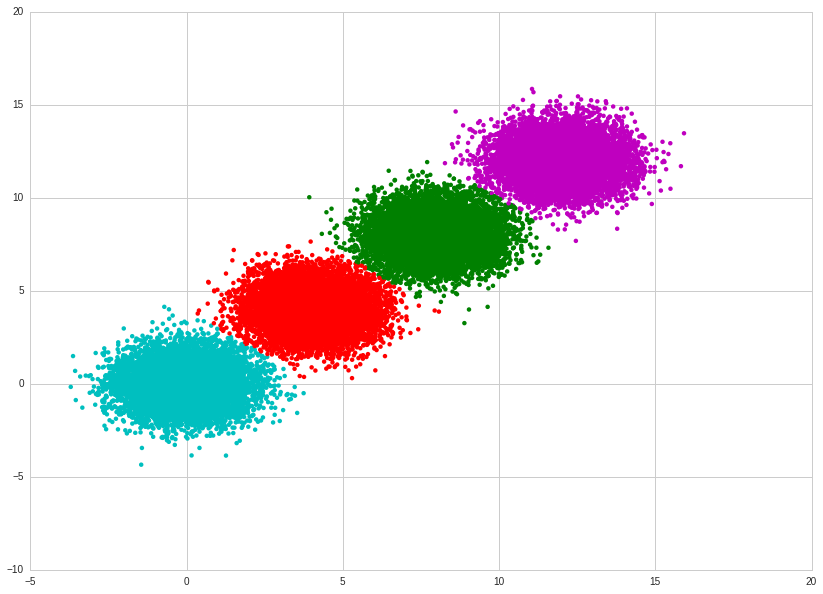

EM took 25.0632140636s


In [39]:
mu = initial_mu.copy()
cov = initial_cov.copy()

tic = time.time()
mu, cov, r = EM(X, mu, cov)
toc = time.time() - tic

r = r.argmax(axis=1)
plt.figure( figsize=(14, 10) )
plt.scatter( X[:,0], X[:,1], c=['cmgr'[i] for i in r], linewidth=0 )
plt.show()
print "EM took {}s".format(toc)

In [40]:
%%cython
import numpy
LOG_2_PI = numpy.log(2*numpy.pi)

def log_probability(X, mu, inv_cov, log_det, d):
    logp = 0.0
    
    for i in range(d):
        for j in range(d):
            logp += (X[i] - mu[i]) * (X[j] - mu[j]) * inv_cov[i, j]
    
    return -0.5 * (d * LOG_2_PI + log_det + logp)
            
def _expectation(X, mu, cov ):
    n = X.shape[0]
    d = X.shape[1]
    log_det = numpy.linalg.slogdet(cov)[1]
    inv_cov_ndarray = numpy.linalg.inv(cov)
    r = numpy.zeros(n)
    
    for i in range(n):
        r[i] = numpy.exp(log_probability(X[i], mu, inv_cov_ndarray, log_det, d ))
    
    return r

def expectation(X, mu, cov):
    r = numpy.hstack((_expectation(X, m, c)[:, numpy.newaxis] for m, c in zip(mu, cov)))
    r = ( r.T / r.T.sum(axis=0) ).T
    return r
    
def covariance(X, weights):
    n, d = X.shape
    mu = numpy.average(X, axis=0, weights=weights)
    cov = numpy.zeros((d, d))
    
    for i in range(d):
        for j in range(i+1):
            cov[i, j] = weights.dot( (X[:,i] - mu[i])*(X[:,j] - mu[j])  )
            cov[j, i] = cov[i, j]
    
    w_sum = weights.sum()
    return cov / w_sum
    
def maximization(X, r):
    mus = numpy.array([ numpy.average(X, axis=0, weights=r[:,i]) for i in range(r.shape[1]) ])
    covs = numpy.array([ covariance(X, r[:,i]) for i in range(r.shape[1]) ])
    return mus, covs
    
def EM(X, mu, cov):
    for i in range(25):
        r = expectation(X, mu, cov)
        mu, cov = maximization(X, r)

    return mu, cov, r

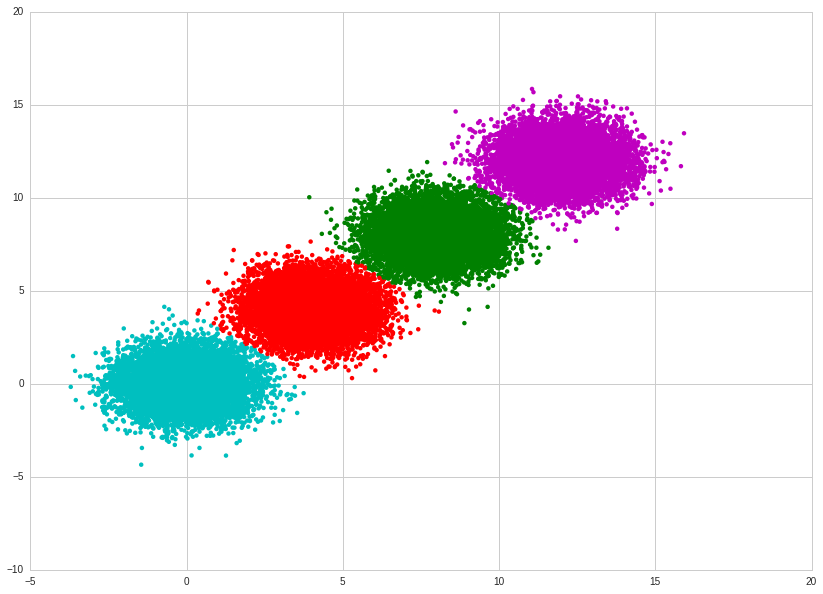

EM took 16.6831400394s


In [41]:
mu = initial_mu.copy()
cov = initial_cov.copy()

tic = time.time()
mu, cov, r = EM(X, mu, cov)
toc = time.time() - tic

r = r.argmax(axis=1)
plt.figure( figsize=(14, 10) )
plt.scatter( X[:,0], X[:,1], c=['cmgr'[i] for i in r], linewidth=0 )
plt.show()
print "EM took {}s".format(toc)

In [42]:
%%cython
import numpy
cimport numpy
LOG_2_PI = numpy.log(2*numpy.pi)

cdef double log_probability(double* X, double* mu, double* inv_cov, double log_det, int d):
    cdef int i, j
    cdef double logp = 0.0
    
    for i in range(d):
        for j in range(d):
            logp += (X[i] - mu[i]) * (X[j] - mu[j]) * inv_cov[i + j*d]
    
    return -0.5 * (d * LOG_2_PI + log_det + logp)
            
cpdef numpy.ndarray _expectation( numpy.ndarray X_ndarray, numpy.ndarray mu_ndarray, numpy.ndarray cov_ndarray ):
    cdef int i, n = X_ndarray.shape[0], d = X_ndarray.shape[1]
    cdef double log_det = numpy.linalg.slogdet(cov_ndarray)[1]
    cdef numpy.ndarray inv_cov_ndarray = numpy.linalg.inv(cov_ndarray)
    cdef numpy.ndarray r = numpy.zeros(n)
    
    cdef double* inv_cov = <double*> inv_cov_ndarray.data
    cdef double* mu = <double*> mu_ndarray.data
    cdef double* X = <double*> X_ndarray.data
    
    for i in range(n):
        r[i] = numpy.exp(log_probability(X + i*d, mu, inv_cov, log_det, d ))
    
    return r

def expectation(X, mu, cov):
    r = numpy.hstack((_expectation(X, m, c)[:, numpy.newaxis] for m, c in zip(mu, cov)))
    r = ( r.T / r.T.sum(axis=0) ).T
    return r
    
def covariance(X, weights):
    n, d = X.shape
    mu = numpy.average(X, axis=0, weights=weights)
    cov = numpy.zeros((d, d))
    
    for i in range(d):
        for j in range(i+1):
            cov[i, j] = weights.dot( (X[:,i] - mu[i])*(X[:,j] - mu[j])  )
            cov[j, i] = cov[i, j]
    
    w_sum = weights.sum()
    return cov / w_sum
    
def maximization(X, r):
    mus = numpy.array([ numpy.average(X, axis=0, weights=r[:,i]) for i in range(r.shape[1]) ])
    covs = numpy.array([ covariance(X, r[:,i]) for i in range(r.shape[1]) ])
    return mus, covs
    
def EM(X, mu, cov):
    for i in range(25):
        r = expectation(X, mu, cov)
        mu, cov = maximization(X, r)

    return mu, cov, r

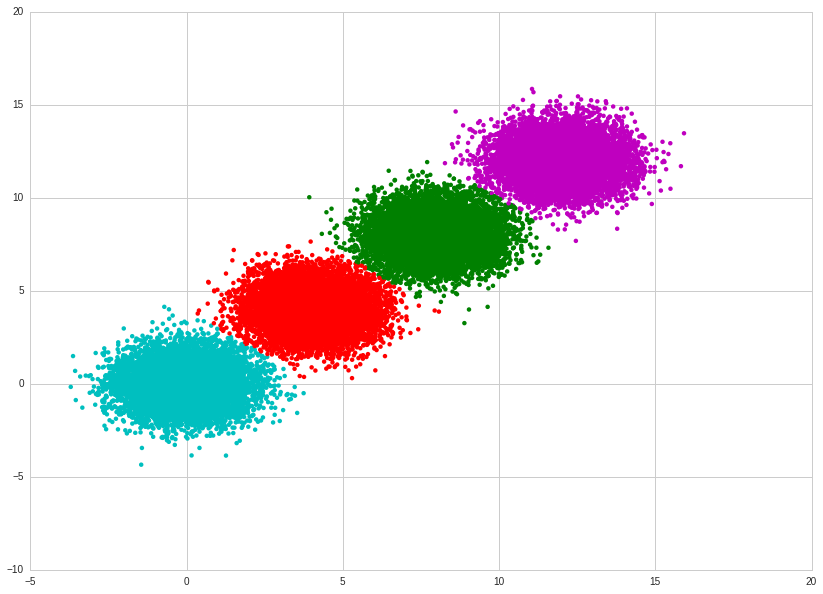

EM took 4.9281308651s


In [43]:
mu = initial_mu.copy()
cov = initial_cov.copy()

tic = time.time()
mu, cov, r = EM(X, mu, cov)
toc = time.time() - tic

r = r.argmax(axis=1)
plt.figure( figsize=(14, 10) )
plt.scatter( X[:,0], X[:,1], c=['cmgr'[i] for i in r], linewidth=0 )
plt.show()
print "EM took {}s".format(toc)

In [44]:
%%cython
import numpy
cimport numpy
from libc.math cimport exp as cexp

DEF LOG_2_PI = 0.79817986835

cdef double log_probability(double* X, double* mu, double* inv_cov, double log_det, int d) nogil:
    cdef int i, j
    cdef double logp = 0.0
    
    for i in range(d):
        for j in range(d):
            logp += (X[i] - mu[i]) * (X[j] - mu[j]) * inv_cov[i + j*d]
    
    return -0.5 * (d * LOG_2_PI + log_det + logp)
            
cpdef numpy.ndarray _expectation( numpy.ndarray X_ndarray, numpy.ndarray mu_ndarray, numpy.ndarray cov_ndarray ):
    cdef int i, n = X_ndarray.shape[0], d = X_ndarray.shape[1]
    cdef double log_det = numpy.linalg.slogdet(cov_ndarray)[1]
    cdef numpy.ndarray inv_cov_ndarray = numpy.linalg.inv(cov_ndarray)
    cdef numpy.ndarray r = numpy.zeros(n)
    
    cdef double* inv_cov = <double*> inv_cov_ndarray.data
    cdef double* mu = <double*> mu_ndarray.data
    cdef double* X = <double*> X_ndarray.data
    
    for i in range(n):
        r[i] = cexp(log_probability(X + i*d, mu, inv_cov, log_det, d ))
    
    return r

def expectation(X, mu, cov):
    r = numpy.hstack((_expectation(X, m, c)[:, numpy.newaxis] for m, c in zip(mu, cov)))
    r = ( r.T / r.T.sum(axis=0) ).T
    return r
    
def covariance(X, weights):
    n, d = X.shape
    mu = numpy.average(X, axis=0, weights=weights)
    cov = numpy.zeros((d, d))
    
    for i in range(d):
        for j in range(i+1):
            cov[i, j] = weights.dot( (X[:,i] - mu[i])*(X[:,j] - mu[j])  )
            cov[j, i] = cov[i, j]
    
    w_sum = weights.sum()
    return cov / w_sum
    
def maximization(X, r):
    mus = numpy.array([ numpy.average(X, axis=0, weights=r[:,i]) for i in range(r.shape[1]) ])
    covs = numpy.array([ covariance(X, r[:,i]) for i in range(r.shape[1]) ])
    return mus, covs
    
def EM(X, mu, cov):
    for i in range(25):
        r = expectation(X, mu, cov)
        mu, cov = maximization(X, r)

    return mu, cov, r

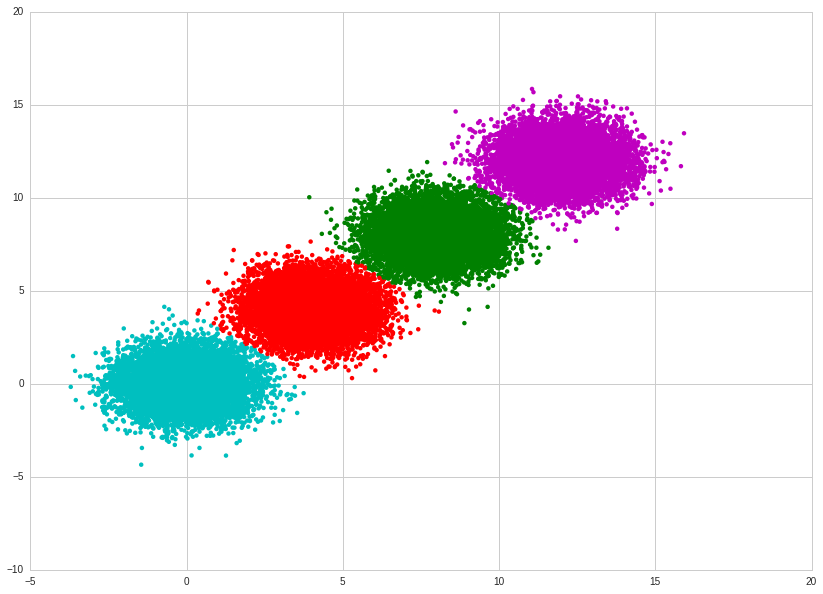

EM took 0.610914945602s


In [45]:
mu = initial_mu.copy()
cov = initial_cov.copy()

tic = time.time()
mu, cov, r = EM(X, mu, cov)
toc = time.time() - tic

r = r.argmax(axis=1)
plt.figure( figsize=(14, 10) )
plt.scatter( X[:,0], X[:,1], c=['cmgr'[i] for i in r], linewidth=0 )
plt.show()
print "EM took {}s".format(toc)

In [46]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force
from cython.parallel cimport prange
import numpy
cimport numpy
from libc.math cimport exp as cexp

DEF LOG_2_PI = 0.79817986835

cdef double log_probability(double* X, double* mu, double* inv_cov, double log_det, int d) nogil:
    cdef int i, j
    cdef double logp = 0.0
    
    for i in range(d):
        for j in range(d):
            logp += (X[i] - mu[i]) * (X[j] - mu[j]) * inv_cov[i + j*d]
    
    return -0.5 * (d * LOG_2_PI + log_det + logp)
            
cpdef numpy.ndarray _expectation( numpy.ndarray X_ndarray, numpy.ndarray mu_ndarray, numpy.ndarray cov_ndarray ):
    cdef int i, n = X_ndarray.shape[0], d = X_ndarray.shape[1]
    cdef double log_det = numpy.linalg.slogdet(cov_ndarray)[1]
    cdef numpy.ndarray inv_cov_ndarray = numpy.linalg.inv(cov_ndarray)
    cdef numpy.ndarray r_ndarray = numpy.zeros(n)
    
    cdef double* inv_cov = <double*> inv_cov_ndarray.data
    cdef double* mu = <double*> mu_ndarray.data
    cdef double* X = <double*> X_ndarray.data
    cdef double* r = <double*> r_ndarray.data
    
    for i in prange(n, nogil=True, num_threads=4, schedule='guided'):
        r[i] = cexp(log_probability(X + i*d, mu, inv_cov, log_det, d ))
    
    return r_ndarray

def expectation(X, mu, cov):
    r = numpy.hstack((_expectation(X, m, c)[:, numpy.newaxis] for m, c in zip(mu, cov)))
    r = ( r.T / r.T.sum(axis=0) ).T
    return r
    
def covariance(X, weights):
    n, d = X.shape
    mu = numpy.average(X, axis=0, weights=weights)
    cov = numpy.zeros((d, d))
    
    for i in range(d):
        for j in range(i+1):
            cov[i, j] = weights.dot( (X[:,i] - mu[i])*(X[:,j] - mu[j])  )
            cov[j, i] = cov[i, j]
    
    w_sum = weights.sum()
    return cov / w_sum
    
def maximization(X, r):
    mus = numpy.array([ numpy.average(X, axis=0, weights=r[:,i]) for i in range(r.shape[1]) ])
    covs = numpy.array([ covariance(X, r[:,i]) for i in range(r.shape[1]) ])
    return mus, covs
    
def EM(X, mu, cov):
    for i in range(25):
        r = expectation(X, mu, cov)
        mu, cov = maximization(X, r)

    return mu, cov, r

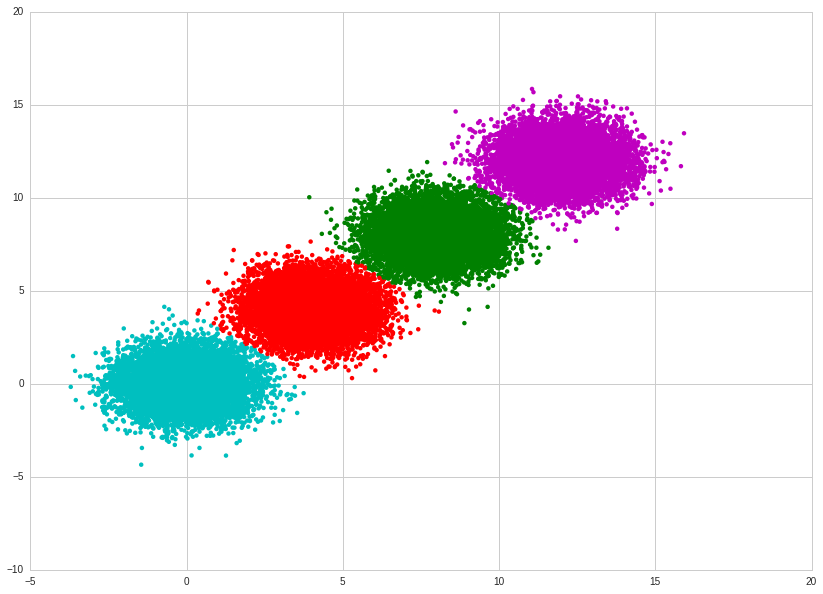

EM took 0.719545125961s


In [47]:
mu = initial_mu.copy()
cov = initial_cov.copy()

tic = time.time()
mu, cov, r = EM(X, mu, cov)
toc = time.time() - tic

r = r.argmax(axis=1)
plt.figure( figsize=(14, 10) )
plt.scatter( X[:,0], X[:,1], c=['cmgr'[i] for i in r], linewidth=0 )
plt.show()
print "EM took {}s".format(toc)

In [48]:
%%cython
import numpy
cimport numpy
from libc.math cimport exp as cexp
from joblib import Parallel, delayed

DEF LOG_2_PI = 0.79817986835

cdef double log_probability(double* X, double* mu, double* inv_cov, double log_det, int d) nogil:
    cdef int i, j
    cdef double logp = 0.0
    
    for i in range(d):
        for j in range(d):
            logp += (X[i] - mu[i]) * (X[j] - mu[j]) * inv_cov[i + j*d]
    
    return -0.5 * (d * LOG_2_PI + log_det + logp)
            
cpdef numpy.ndarray _expectation( numpy.ndarray X_ndarray, numpy.ndarray mu_ndarray, numpy.ndarray cov_ndarray ):
    cdef int i, n = X_ndarray.shape[0], d = X_ndarray.shape[1]
    cdef double log_det = numpy.linalg.slogdet(cov_ndarray)[1]
    cdef numpy.ndarray inv_cov_ndarray = numpy.linalg.inv(cov_ndarray)
    cdef numpy.ndarray r_ndarray = numpy.zeros(n)
    
    cdef double* inv_cov = <double*> inv_cov_ndarray.data
    cdef double* mu = <double*> mu_ndarray.data
    cdef double* X = <double*> X_ndarray.data
    cdef double* r = <double*> r_ndarray.data
    
    with nogil:
        for i in range(n):
            r[i] = cexp(log_probability(X + i*d, mu, inv_cov, log_det, d ))
    
    return r_ndarray

def expectation(X, mu, cov):
    with Parallel(n_jobs=1, backend='threading') as parallel:
        r = parallel([ delayed(_expectation, check_pickle=False)(X, m, c) for m, c in zip(mu, cov) ])
        r = numpy.hstack([ a[:, numpy.newaxis] for a in r ])
        r = ( r.T / r.T.sum(axis=0) ).T
    return r
    
def covariance(X, weights):
    n, d = X.shape
    mu = numpy.average(X, axis=0, weights=weights)
    cov = numpy.zeros((d, d))
    
    for i in range(d):
        for j in range(i+1):
            cov[i, j] = weights.dot( (X[:,i] - mu[i])*(X[:,j] - mu[j])  )
            cov[j, i] = cov[i, j]
    
    w_sum = weights.sum()
    return cov / w_sum
    
def maximization(X, r):
    mus = numpy.array([ numpy.average(X, axis=0, weights=r[:,i]) for i in range(r.shape[1]) ])
    covs = numpy.array([ covariance(X, r[:,i]) for i in range(r.shape[1]) ])
    return mus, covs
    
def EM(X, mu, cov):
    for i in range(25):
        r = expectation(X, mu, cov)
        mu, cov = maximization(X, r)

    return mu, cov, r

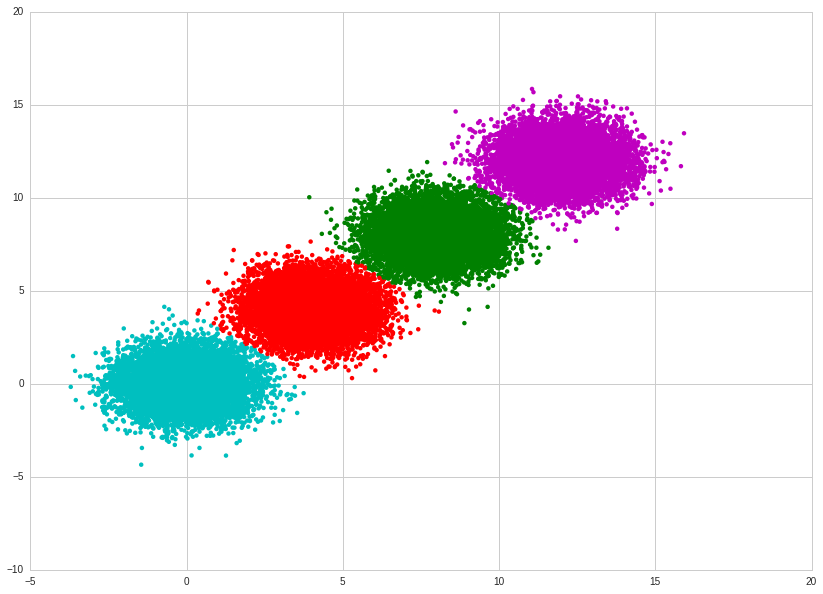

EM took 0.486299037933s


In [49]:
mu = initial_mu.copy()
cov = initial_cov.copy()

tic = time.time()
mu, cov, r = EM(X, mu, cov)
toc = time.time() - tic

r = r.argmax(axis=1)
plt.figure( figsize=(14, 10) )
plt.scatter( X[:,0], X[:,1], c=['cmgr'[i] for i in r], linewidth=0 )
plt.show()
print "EM took {}s".format(toc)